In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import GPT2Model, GPT2Tokenizer
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [2]:
# Load the data
df = pd.read_csv('author_ratings_normalized.csv', lineterminator='\n')

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a pad token by default
model = GPT2Model.from_pretrained(model_name)
model.to(device)
model.eval()  # Set to evaluation mode


Using device: cuda


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [3]:
# Function to extract embeddings for a question-answer pair
def extract_embedding(question, answer, model, tokenizer, device):
    """
    Extract the embedding from GPT-2 for a given question-answer pair
    
    Args:
        question (str): The question
        answer (str): The answer
        model: The GPT-2 model
        tokenizer: The tokenizer
        device: The device to use for processing
        
    Returns:
        numpy.ndarray: The embedding vector
    """
    # Combine question and answer
    text = f"Question: {question} Answer: {answer}"
    
    # Tokenize input
    encoded_input = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )
    
    # Move inputs to device
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    # Get the embedding
    with torch.no_grad():
        outputs = model(**encoded_input)
        last_hidden_state = outputs.last_hidden_state
        
        # Get the last token's embedding
        last_token_id = encoded_input['attention_mask'].sum(dim=1) - 1
        last_token_id = last_token_id.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, last_hidden_state.size(-1))
        last_token_embedding = torch.gather(last_hidden_state, 1, last_token_id).squeeze(1)
        
        # Return as numpy array
        return last_token_embedding.cpu().numpy().flatten()

In [4]:
# STEP 1: Extract embeddings and save them separately
print("STEP 1: Extracting embeddings for each question-answer pair...")
embeddings = []
row_indices = []  # Store original row indices for later merging

# Process in batches to avoid memory issues
batch_size = 100
num_batches = len(df) // batch_size + (1 if len(df) % batch_size != 0 else 0)

for batch_idx in tqdm(range(num_batches), desc="Processing batches"):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(df))
    batch_df = df.iloc[start_idx:end_idx]
    
    for idx, row in batch_df.iterrows():
        question = row['question']
        answer = row['answer']
        
        # Extract embedding
        embedding = extract_embedding(question, answer, model, tokenizer, device)
        
        # Save embedding and row index
        embeddings.append(embedding)
        row_indices.append(idx)
        
        # Periodically save progress to avoid data loss
        if len(embeddings) % 1000 == 0:
            print(f"Processed {len(embeddings)} samples...")
            
            # Create temp dataframe with current embeddings
            temp_embedding_df = pd.DataFrame(embeddings)
            temp_embedding_df['original_index'] = row_indices
            
            # Save temp files
            temp_embedding_df.to_csv('gpt2_embeddings_temp.csv', index=False)


STEP 1: Extracting embeddings for each question-answer pair...


Processing batches:   1%|▋                                                              | 9/777 [00:22<30:50,  2.41s/it]

Processed 1000 samples...


Processing batches:   2%|█▌                                                            | 19/777 [00:46<30:45,  2.44s/it]

Processed 2000 samples...


Processing batches:   4%|██▎                                                           | 29/777 [01:11<30:17,  2.43s/it]

Processed 3000 samples...


Processing batches:   5%|███                                                           | 39/777 [01:37<29:57,  2.44s/it]

Processed 4000 samples...


Processing batches:   6%|███▉                                                          | 49/777 [02:03<29:26,  2.43s/it]

Processed 5000 samples...


Processing batches:   8%|████▋                                                         | 59/777 [02:29<29:06,  2.43s/it]

Processed 6000 samples...


Processing batches:   9%|█████▌                                                        | 69/777 [02:56<28:52,  2.45s/it]

Processed 7000 samples...


Processing batches:  10%|██████▎                                                       | 79/777 [03:23<28:30,  2.45s/it]

Processed 8000 samples...


Processing batches:  11%|███████                                                       | 89/777 [03:51<28:02,  2.44s/it]

Processed 9000 samples...


Processing batches:  13%|███████▉                                                      | 99/777 [04:19<27:51,  2.47s/it]

Processed 10000 samples...


Processing batches:  14%|████████▌                                                    | 109/777 [04:48<27:32,  2.47s/it]

Processed 11000 samples...


Processing batches:  15%|█████████▎                                                   | 119/777 [05:17<27:06,  2.47s/it]

Processed 12000 samples...


Processing batches:  17%|██████████▏                                                  | 129/777 [05:47<26:54,  2.49s/it]

Processed 13000 samples...


Processing batches:  18%|██████████▉                                                  | 139/777 [06:17<26:19,  2.48s/it]

Processed 14000 samples...


Processing batches:  19%|███████████▋                                                 | 149/777 [06:47<25:57,  2.48s/it]

Processed 15000 samples...


Processing batches:  20%|████████████▍                                                | 159/777 [07:18<25:34,  2.48s/it]

Processed 16000 samples...


Processing batches:  22%|█████████████▎                                               | 169/777 [07:49<25:17,  2.50s/it]

Processed 17000 samples...


Processing batches:  23%|██████████████                                               | 179/777 [08:21<24:48,  2.49s/it]

Processed 18000 samples...


Processing batches:  24%|██████████████▊                                              | 189/777 [08:53<24:33,  2.51s/it]

Processed 19000 samples...


Processing batches:  26%|███████████████▌                                             | 199/777 [09:25<24:05,  2.50s/it]

Processed 20000 samples...


Processing batches:  27%|████████████████▍                                            | 209/777 [09:59<23:51,  2.52s/it]

Processed 21000 samples...


Processing batches:  28%|█████████████████▏                                           | 219/777 [10:33<23:25,  2.52s/it]

Processed 22000 samples...


Processing batches:  29%|█████████████████▉                                           | 229/777 [11:07<23:03,  2.53s/it]

Processed 23000 samples...


Processing batches:  31%|██████████████████▊                                          | 239/777 [11:41<22:59,  2.56s/it]

Processed 24000 samples...


Processing batches:  32%|███████████████████▌                                         | 249/777 [12:16<22:13,  2.53s/it]

Processed 25000 samples...


Processing batches:  33%|████████████████████▎                                        | 259/777 [12:51<22:09,  2.57s/it]

Processed 26000 samples...


Processing batches:  35%|█████████████████████                                        | 269/777 [13:27<21:45,  2.57s/it]

Processed 27000 samples...


Processing batches:  36%|█████████████████████▉                                       | 279/777 [14:05<21:39,  2.61s/it]

Processed 28000 samples...


Processing batches:  37%|██████████████████████▋                                      | 289/777 [14:42<21:02,  2.59s/it]

Processed 29000 samples...


Processing batches:  38%|███████████████████████▍                                     | 299/777 [15:20<20:23,  2.56s/it]

Processed 30000 samples...


Processing batches:  40%|████████████████████████▎                                    | 309/777 [15:57<19:56,  2.56s/it]

Processed 31000 samples...


Processing batches:  41%|█████████████████████████                                    | 319/777 [16:35<19:35,  2.57s/it]

Processed 32000 samples...


Processing batches:  42%|█████████████████████████▊                                   | 329/777 [17:13<19:09,  2.57s/it]

Processed 33000 samples...


Processing batches:  44%|██████████████████████████▌                                  | 339/777 [17:53<18:52,  2.59s/it]

Processed 34000 samples...


Processing batches:  45%|███████████████████████████▍                                 | 349/777 [18:32<18:29,  2.59s/it]

Processed 35000 samples...


Processing batches:  46%|████████████████████████████▏                                | 359/777 [19:13<18:05,  2.60s/it]

Processed 36000 samples...


Processing batches:  47%|████████████████████████████▉                                | 369/777 [19:53<17:36,  2.59s/it]

Processed 37000 samples...


Processing batches:  49%|█████████████████████████████▊                               | 379/777 [20:34<17:14,  2.60s/it]

Processed 38000 samples...


Processing batches:  50%|██████████████████████████████▌                              | 389/777 [21:15<16:54,  2.61s/it]

Processed 39000 samples...


Processing batches:  51%|███████████████████████████████▎                             | 399/777 [21:58<16:28,  2.61s/it]

Processed 40000 samples...


Processing batches:  53%|████████████████████████████████                             | 409/777 [22:40<16:13,  2.65s/it]

Processed 41000 samples...


Processing batches:  54%|████████████████████████████████▉                            | 419/777 [23:23<15:37,  2.62s/it]

Processed 42000 samples...


Processing batches:  55%|█████████████████████████████████▋                           | 429/777 [24:06<15:15,  2.63s/it]

Processed 43000 samples...


Processing batches:  56%|██████████████████████████████████▍                          | 439/777 [24:50<14:51,  2.64s/it]

Processed 44000 samples...


Processing batches:  58%|███████████████████████████████████▏                         | 449/777 [25:34<14:26,  2.64s/it]

Processed 45000 samples...


Processing batches:  59%|████████████████████████████████████                         | 459/777 [26:20<14:05,  2.66s/it]

Processed 46000 samples...


Processing batches:  60%|████████████████████████████████████▊                        | 469/777 [27:05<13:34,  2.65s/it]

Processed 47000 samples...


Processing batches:  62%|█████████████████████████████████████▌                       | 479/777 [27:51<13:13,  2.66s/it]

Processed 48000 samples...


Processing batches:  63%|██████████████████████████████████████▍                      | 489/777 [28:37<12:53,  2.69s/it]

Processed 49000 samples...


Processing batches:  64%|███████████████████████████████████████▏                     | 499/777 [29:23<12:24,  2.68s/it]

Processed 50000 samples...


Processing batches:  66%|███████████████████████████████████████▉                     | 509/777 [30:11<11:59,  2.68s/it]

Processed 51000 samples...


Processing batches:  67%|████████████████████████████████████████▋                    | 519/777 [30:59<11:30,  2.68s/it]

Processed 52000 samples...


Processing batches:  68%|█████████████████████████████████████████▌                   | 529/777 [31:48<11:10,  2.70s/it]

Processed 53000 samples...


Processing batches:  69%|██████████████████████████████████████████▎                  | 539/777 [32:36<10:46,  2.72s/it]

Processed 54000 samples...


Processing batches:  71%|███████████████████████████████████████████                  | 549/777 [33:26<10:15,  2.70s/it]

Processed 55000 samples...


Processing batches:  72%|███████████████████████████████████████████▉                 | 559/777 [34:16<09:50,  2.71s/it]

Processed 56000 samples...


Processing batches:  73%|████████████████████████████████████████████▋                | 569/777 [35:07<09:25,  2.72s/it]

Processed 57000 samples...


Processing batches:  75%|█████████████████████████████████████████████▍               | 579/777 [35:58<08:58,  2.72s/it]

Processed 58000 samples...


Processing batches:  76%|██████████████████████████████████████████████▏              | 589/777 [36:50<08:33,  2.73s/it]

Processed 59000 samples...


Processing batches:  77%|███████████████████████████████████████████████              | 599/777 [37:41<08:12,  2.77s/it]

Processed 60000 samples...


Processing batches:  78%|███████████████████████████████████████████████▊             | 609/777 [38:34<07:39,  2.73s/it]

Processed 61000 samples...


Processing batches:  80%|████████████████████████████████████████████████▌            | 619/777 [39:31<07:21,  2.79s/it]

Processed 62000 samples...


Processing batches:  81%|█████████████████████████████████████████████████▍           | 629/777 [40:24<06:48,  2.76s/it]

Processed 63000 samples...


Processing batches:  82%|██████████████████████████████████████████████████▏          | 639/777 [41:18<06:20,  2.76s/it]

Processed 64000 samples...


Processing batches:  84%|██████████████████████████████████████████████████▉          | 649/777 [42:13<05:54,  2.77s/it]

Processed 65000 samples...


Processing batches:  85%|███████████████████████████████████████████████████▋         | 659/777 [43:09<05:28,  2.79s/it]

Processed 66000 samples...


Processing batches:  86%|████████████████████████████████████████████████████▌        | 669/777 [44:04<05:01,  2.79s/it]

Processed 67000 samples...


Processing batches:  87%|█████████████████████████████████████████████████████▎       | 679/777 [45:01<04:33,  2.79s/it]

Processed 68000 samples...


Processing batches:  89%|██████████████████████████████████████████████████████       | 689/777 [45:58<04:06,  2.80s/it]

Processed 69000 samples...


Processing batches:  90%|██████████████████████████████████████████████████████▉      | 699/777 [46:55<03:38,  2.80s/it]

Processed 70000 samples...


Processing batches:  91%|███████████████████████████████████████████████████████▋     | 709/777 [47:52<03:10,  2.80s/it]

Processed 71000 samples...


Processing batches:  93%|████████████████████████████████████████████████████████▍    | 719/777 [48:50<02:43,  2.81s/it]

Processed 72000 samples...


Processing batches:  94%|█████████████████████████████████████████████████████████▏   | 729/777 [49:50<02:15,  2.82s/it]

Processed 73000 samples...


Processing batches:  95%|██████████████████████████████████████████████████████████   | 739/777 [50:49<01:47,  2.82s/it]

Processed 74000 samples...


Processing batches:  96%|██████████████████████████████████████████████████████████▊  | 749/777 [51:48<01:18,  2.82s/it]

Processed 75000 samples...


Processing batches:  98%|███████████████████████████████████████████████████████████▌ | 759/777 [52:48<00:51,  2.84s/it]

Processed 76000 samples...


Processing batches:  99%|████████████████████████████████████████████████████████████▎| 769/777 [53:48<00:22,  2.84s/it]

Processed 77000 samples...


Processing batches: 100%|█████████████████████████████████████████████████████████████| 777/777 [54:42<00:00,  4.23s/it]


In [5]:
# Convert embeddings to DataFrame
print("Creating embeddings DataFrame...")
embedding_df = pd.DataFrame(embeddings)
embedding_df['original_index'] = row_indices

# Save embeddings
print("Saving embeddings...")
embedding_df.to_csv('gpt2_embeddings.csv', index=False)
with open('gpt2_embeddings.pkl', 'wb') as f:
    pickle.dump({'embeddings': embeddings, 'indices': row_indices}, f)

print(f"Saved embeddings with shape: {embedding_df.shape}")

Creating embeddings DataFrame...
Saving embeddings...
Saved embeddings with shape: (77603, 769)


In [6]:
# STEP 2: Add embeddings to the original DataFrame
print("\nSTEP 2: Adding embeddings to the original DataFrame...")

# First, determine embedding size
embedding_size = embedding_df.shape[1] - 1  # -1 for the original_index column
print(f"Embedding size: {embedding_size}")

# Create a prefix for embedding columns
embedding_prefix = "embedding_"

# Create empty columns in the original dataframe for embeddings
for i in range(embedding_size):
    df[f"{embedding_prefix}{i}"] = None

# Add embeddings to the original dataframe
print("Transferring embeddings to the original DataFrame...")
for idx, emb_row in tqdm(embedding_df.iterrows(), total=len(embedding_df), desc="Adding embeddings"):
    original_idx = emb_row['original_index']
    
    # Get embedding values (all columns except 'original_index')
    emb_values = emb_row.drop('original_index').values
    
    # Add each embedding dimension to the original dataframe
    for i in range(embedding_size):
        df.at[original_idx, f"{embedding_prefix}{i}"] = emb_values[i]


STEP 2: Adding embeddings to the original DataFrame...
Embedding size: 768


/tmp/ipykernel_1506/1639772287.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{embedding_prefix}{i}"] = None
/tmp/ipykernel_1506/1639772287.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{embedding_prefix}{i}"] = None
/tmp/ipykernel_1506/1639772287.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newf

Transferring embeddings to the original DataFrame...


Adding embeddings: 100%|█████████████████████████████████████████████████████████| 77603/77603 [06:55<00:00, 186.88it/s]


In [7]:
# Save the enhanced dataframe
print("Saving the enhanced DataFrame...")
df.to_csv('author_ratings_with_embeddings.csv', index=False)

Saving the enhanced DataFrame...


In [8]:
df = pd.read_csv('author_ratings_with_embeddings.csv', lineterminator='\n')

Reward statistics:
count    77603.000000
mean         0.500665
std          0.216169
min          0.000000
25%          0.256490
50%          0.504351
75%          0.752212
max          1.000000
Name: reward, dtype: float64


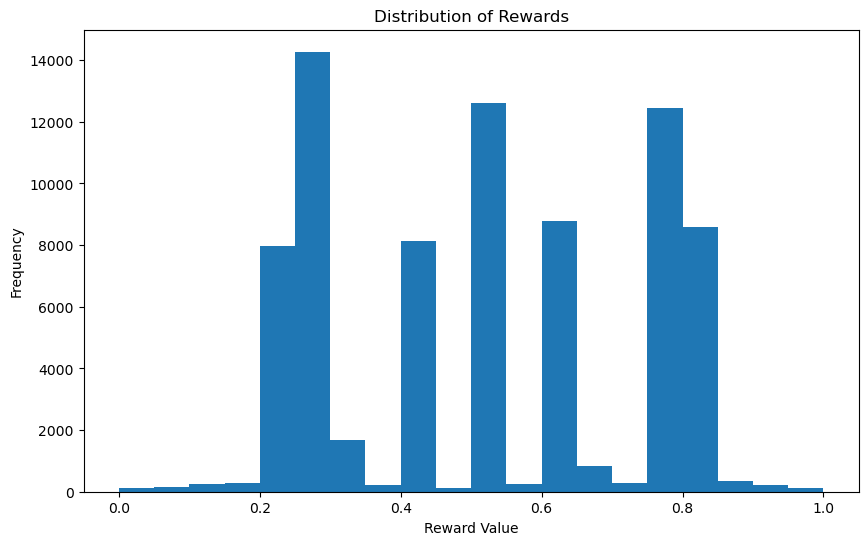

In [9]:
# Create pessimistic target 
a = .05
b = .1
df['reward_p'] = df['rating_norm'] - a*df['rd_norm'] - b*df['volatility_norm']
df['reward'] = df['rating_norm']
# Display reward statistics
print(f"Reward statistics:\n{df['reward'].describe()}")

# Plot reward distribution
plt.figure(figsize=(10, 6))
plt.hist(df['reward'], bins=20)
plt.title('Distribution of Rewards')
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.show()

# Ensure column names match expected format
if "question" not in df.columns and "questions" in df.columns:
    df = df.rename(columns={"questions": "question"})
if "answer" not in df.columns and "answers" in df.columns:
    df = df.rename(columns={"answers": "answer"})
if "reward" not in df.columns and "rewards" in df.columns:
    df = df.rename(columns={"rewards": "reward"})

In [10]:
# Get embedding columns
embedding_cols = [col for col in df.columns if col.startswith('embedding_')]

# Split the data for machine learning
from sklearn.model_selection import train_test_split
X = df[embedding_cols]
y = df['reward']  # or any target column

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Train a model (example with Ridge regression)
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R²: {r2_score(y_test, y_pred)}')

MSE: 0.04534286479087771
R²: 0.0180513510741791


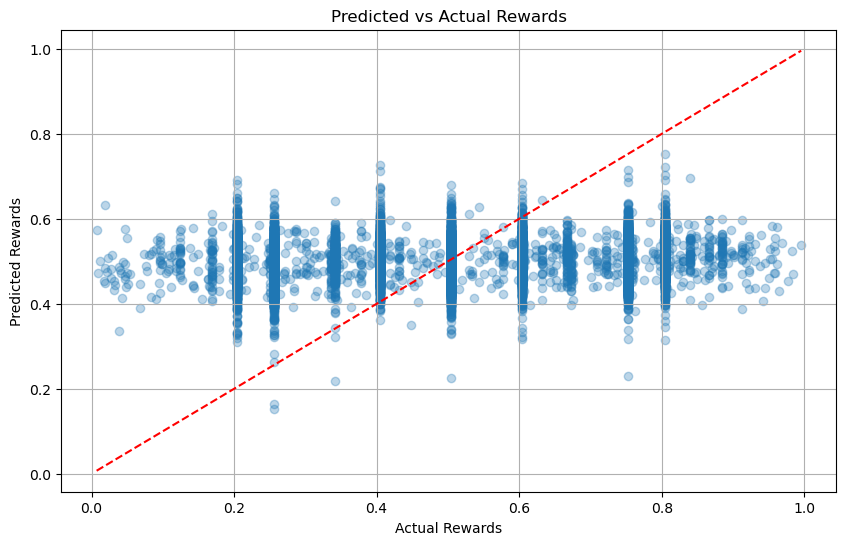

In [13]:
# 12. Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Rewards')
plt.ylabel('Predicted Rewards')
plt.title('Predicted vs Actual Rewards')
plt.grid(True)
plt.savefig('predictions_vs_actuals.png')
plt.show()

Neural Network approach

In [14]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# Make sure 'reward' column exists, otherwise use 'rating_norm'
target_col = 'reward' if 'reward' in df.columns else 'rating_norm'
print(f"Using '{target_col}' as target column")

X = df[embedding_cols].values
y = df[target_col].values

Using 'reward' as target column


In [16]:
# 3. Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 54322 samples
Validation set: 11640 samples
Test set: 11641 samples


In [17]:
# 4. Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 5. Create PyTorch datasets and dataloaders
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = EmbeddingDataset(X_train, y_train)
val_dataset = EmbeddingDataset(X_val, y_val)
test_dataset = EmbeddingDataset(X_test, y_test)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 6. Define the feed-forward neural network
class FeedForwardNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1, dropout_rate=0.2):
        super(FeedForwardNet, self).__init__()
        
        # Build layers dynamically based on hidden_sizes list
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        # Additional hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Combine all layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train.shape[1]  # Number of embedding dimensions
hidden_sizes = [128, 32]  # Hidden layer sizes
output_size = 1  # Predicting a single reward value
dropout_rate = 0.4  # Dropout rate for regularization

# Instantiate the model
model = FeedForwardNet(input_size, hidden_sizes, output_size, dropout_rate)
model.to(device)
print(model)

# 7. Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00075, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# 8. Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    # Lists to store training history
    train_losses = []
    val_losses = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, best_val_loss








FeedForwardNet(
  (model): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


Starting model training...


Epoch 1/100 - Train Loss: 0.070661, Val Loss: 0.048689


Epoch 2/100 - Train Loss: 0.054033, Val Loss: 0.045661


Epoch 3/100 - Train Loss: 0.048970, Val Loss: 0.045382


Epoch 4/100 - Train Loss: 0.046838, Val Loss: 0.045210


Epoch 5/100 - Train Loss: 0.046137, Val Loss: 0.045188


Epoch 6/100 - Train Loss: 0.045733, Val Loss: 0.045199


Epoch 7/100 - Train Loss: 0.045656, Val Loss: 0.045233


Epoch 8/100 - Train Loss: 0.045585, Val Loss: 0.045167


Epoch 9/100 - Train Loss: 0.045619, Val Loss: 0.045200


Epoch 10/100 - Train Loss: 0.045439, Val Loss: 0.045343


Epoch 11/100 - Train Loss: 0.045389, Val Loss: 0.045134


Epoch 12/100 - Train Loss: 0.045315, Val Loss: 0.045414


Epoch 13/100 - Train Loss: 0.045238, Val Loss: 0.045344


Epoch 14/100 - Train Loss: 0.045169, Val Loss: 0.045279


Epoch 15/100 - Train Loss: 0.045019, Val Loss: 0.045326


Epoch 16/100 - Train Loss: 0.044828, Val Loss: 0.045341


Epoch 17/100 - Train Loss: 0.044811, Val Loss: 0.045354


Epoch 18/100 - Train Loss: 0.044689, Val Loss: 0.045285


Epoch 19/100 - Train Loss: 0.044505, Val Loss: 0.045457


Epoch 20/100 - Train Loss: 0.044286, Val Loss: 0.045446


Epoch 21/100 - Train Loss: 0.044162, Val Loss: 0.045553


Epoch 22/100 - Train Loss: 0.043920, Val Loss: 0.045889


Epoch 23/100 - Train Loss: 0.043113, Val Loss: 0.046144


Epoch 24/100 - Train Loss: 0.042860, Val Loss: 0.046153


Epoch 25/100 - Train Loss: 0.042660, Val Loss: 0.046255


Epoch 26/100 - Train Loss: 0.042295, Val Loss: 0.046594
Early stopping triggered after 26 epochs
Best validation loss: 0.045134


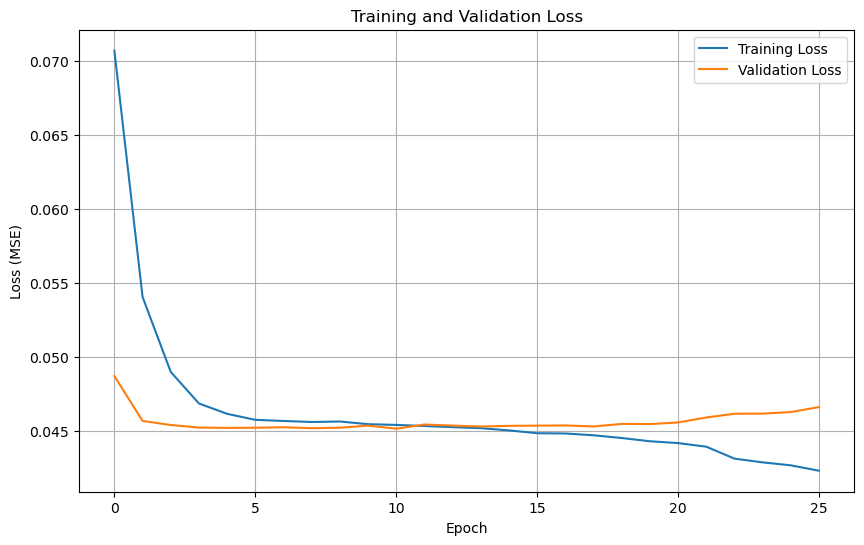

In [18]:
# 9. Train the model
print("Starting model training...")
num_epochs = 100
patience = 15
model, train_losses, val_losses, best_val_loss = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience
)

print(f"Best validation loss: {best_val_loss:.6f}")

# 10. Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_history.png')
plt.show()



In [19]:
# 11. Evaluate on test set
model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        test_loss += loss.item() * inputs.size(0)
        
        # Store predictions and actual values
        predictions.extend(outputs.cpu().numpy().flatten())
        actuals.extend(targets.cpu().numpy().flatten())

test_loss /= len(test_loader.dataset)
print(f"Test Loss (MSE): {test_loss:.6f}")

# Calculate additional metrics
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Mean Absolute Error: {mae:.6f}")

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 974.96it/s]

Test Loss (MSE): 0.047061
Mean Absolute Error: 0.187384


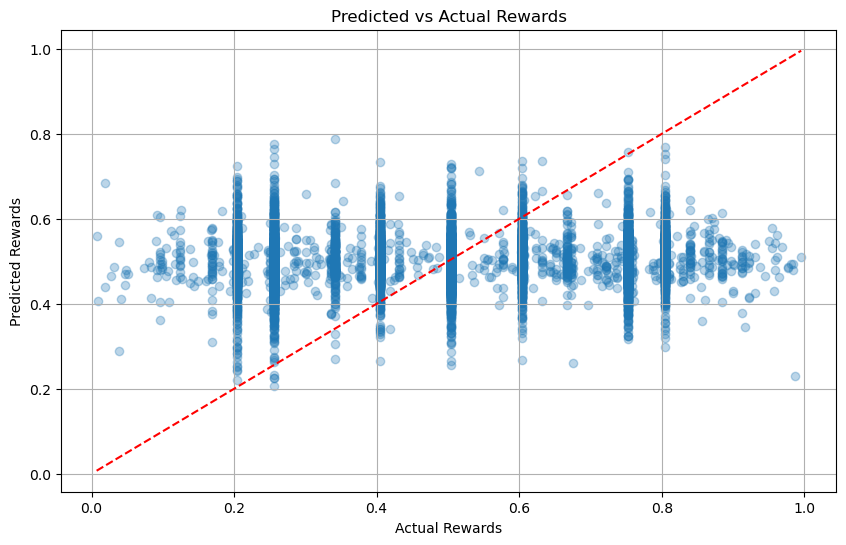

In [20]:
# 12. Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.3)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.xlabel('Actual Rewards')
plt.ylabel('Predicted Rewards')
plt.title('Predicted vs Actual Rewards')
plt.grid(True)
plt.savefig('predictions_vs_actuals.png')
plt.show()

In [21]:
# 13. Save the model and scaler
print("Saving model and scaler...")
torch.save({
    'model_state_dict': model.state_dict(),
    'hidden_sizes': hidden_sizes,
    'input_size': input_size,
    'output_size': output_size,
    'dropout_rate': dropout_rate
}, 'reward_predictor_model.pth')

with open('reward_predictor_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully!")


Saving model and scaler...
Model and scaler saved successfully!


In [22]:

# 14. Function to use the model for new predictions
def predict_reward(question, answer, model, scaler, tokenizer, gpt2_model, device=None):
    """
    Predict reward for a new question-answer pair
    
    Args:
        question (str): The question
        answer (str): The answer
        model: The trained FFN model
        scaler: The feature scaler
        tokenizer: The GPT-2 tokenizer
        gpt2_model: The GPT-2 model for embedding extraction
        device: The device to use
        
    Returns:
        float: The predicted reward
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set models to evaluation mode
    model.eval()
    gpt2_model.eval()
    
    # Extract embedding from GPT-2
    text = f"Question: {question} Answer: {answer}"
    encoded_input = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    with torch.no_grad():
        # Get GPT-2 embedding
        outputs = gpt2_model(**encoded_input)
        last_hidden_state = outputs.last_hidden_state
        last_token_id = encoded_input['attention_mask'].sum(dim=1) - 1
        last_token_id = last_token_id.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, last_hidden_state.size(-1))
        embedding = torch.gather(last_hidden_state, 1, last_token_id).squeeze(1).cpu().numpy().flatten()
        
        # Scale the embedding
        scaled_embedding = scaler.transform(embedding.reshape(1, -1))
        
        # Make prediction
        tensor_input = torch.tensor(scaled_embedding, dtype=torch.float32).to(device)
        prediction = model(tensor_input)
        
    return prediction.item()